In [2]:
!ls ../caueeg/

abnormal-no-overlap.json annotation.xlsx          dementia.json
abnormal.json            conn_data                event
annotation.json          dementia-no-overlap.json signal


In [3]:
import json
f = open('../caueeg/abnormal.json')
data_files = json.load(f)
f.close()

In [4]:
data_files["train_split"][0]

{'serial': '01258',
 'age': 77,
 'symptom': ['dementia', 'vd', 'sivd'],
 'class_name': 'Abnormal',
 'class_label': 1}

In [5]:
idx2label = {}
for file_idx in data_files["train_split"]:
    idx2label[file_idx["serial"]] = file_idx["class_label"]
for file_idx in data_files["test_split"]:
    idx2label[file_idx["serial"]] = file_idx["class_label"]
for file_idx in data_files["validation_split"]:
    idx2label[file_idx["serial"]] = file_idx["class_label"]

In [6]:
len(data_files["train_split"])

1107

In [7]:
len(data_files["test_split"])

136

In [8]:
len(data_files["validation_split"])

136

In [9]:
import glob, os
files = []
for file in glob.glob("../caueeg/signal/edf/*.edf"):
    files.append(file)
print(len(files))

1379


In [10]:
import glob, os
test_data_files = []
for file_name in data_files["test_split"]:
    test_data_files.append("../caueeg/signal/edf/"+file_name["serial"]+".edf")
print(len(test_data_files))

train_data_files = []
for file_name in data_files["train_split"]:
    train_data_files.append("../caueeg/signal/edf/"+file_name["serial"]+".edf")
for file_name in data_files["validation_split"]:
    train_data_files.append("../caueeg/signal/edf/"+file_name["serial"]+".edf")
print(len(train_data_files))

136
1243


In [11]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.modules.module import Module
from sklearn.preprocessing import OneHotEncoder

/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
import mne
import numpy as np

file = train_data_files[0]
data = mne.io.read_raw(file, verbose=False, preload=True)

data.filter(l_freq=0.5, h_freq=47, verbose=False)
data = data.get_data()*1e6
data.shape

(21, 183400)

In [13]:
import mne
from tqdm import tqdm
from statsmodels.tsa.stattools import grangercausalitytests
import random
import numpy as np
from scipy.signal import savgol_filter
from scipy import signal
import cv2
from numpy import *
from scipy.stats import iqr
from scipy.integrate import simps
from scipy.stats import entropy
from scipy.signal import medfilt
from scipy.stats import differential_entropy, norm
from scipy import fftpack
import antropy as ant

def calcGrangerCausality(eegData,ii,jj):
    X = np.vstack([eegData[ii,:],eegData[jj,:]]).T
    gc = grangercausalitytests(X, 1, addconst=True, verbose=False)[1][0]['ssr_ftest'][0]
    return gc

    
def get_label(file):
    idx = file.split("/")[-1][:-4]
    label = idx2label[idx]
    if label == 0:
        return [0]
    elif label == 1:
        return [1]


def lyapunov(x):
    return np.mean(np.log(np.abs(np.gradient(x))))


def build_data(raw_data, bands=False):
    
    eeg_data = []
    labels = []
    lengths = []
    groups = []
    i = 0
    fs = 100
    
    data_features = []
    data_labels = []
    data_graphs = []
    
    for file in tqdm(raw_data):
        
        #get label
        label = get_label(file)
        data_labels.append(label)
        
        #node features
        sample_features = []
        data = mne.io.read_raw(file, verbose=False, preload=True)
        ch_names = data.ch_names
        #data.resample(sfreq=100)
        data.filter(l_freq=0.5, h_freq=40, verbose=False)
        #data = mne.make_fixed_length_epochs(data, duration=5, overlap=1, verbose=False)
        data = data.get_data()*1e6
          
        #data = np.diff(data)    
        #gc = []
        #for i in range(21):
        #    gc1 = []
        #    for j in range(21):
        #        gc1.append(calcGrangerCausality(data, i, j))
        #    gc.append(gc1)
        #data_graphs.append(gc)    
        
        
        ch_features = []    
        # freq domain features
        sf = 256
        win = 4 * sf # win size 4 seconds * sampling freq
        # delta (0.5–4 Hz), theta (4–8 Hz), alpha (8–13 Hz), beta (13–30 Hz), and gamma (30–... Hz).
        freq_ranges = [[0.5, 4], [4, 8], [8, 13], [13, 30], [30, 47]]
        for ch in data:
            
            ch_features.append(differential_entropy(ch))
        
            ly = lyapunov(ch)
            #ch_features.append(ly)
        
            entropy = ant.perm_entropy(ch, normalize=True)
            ch_features.append(entropy)
        
            entropy = ant.spectral_entropy(ch, sf=100, method='welch', normalize=True)
            ch_features.append(entropy)
        
            mobility = ant.hjorth_params(ch)
            ch_features.append(mobility[0])
            ch_features.append(mobility[1])
        
            zero_cross_count = ant.num_zerocross(ch)
            ch_features.append(zero_cross_count)
            
            
            if bands:
                # freq domain features
                for freq_band in freq_ranges:
                
                    # differential entropy
                    sos = signal.butter(10, (freq_band[0], freq_band[1]), 'bandpass', fs=1000, output='sos')
                    filtered_ch = signal.sosfilt(sos, ch) 
                    ch_features.append(differential_entropy(filtered_ch))

                    # lyapunov features
                    ch_features.append(lyapunov(filtered_ch))

                    # Permutation entropy
                    entropy = ant.perm_entropy(filtered_ch, normalize=True)
                    ch_features.append(entropy)

                    # Spectral entropy
                    entropy = ant.spectral_entropy(filtered_ch, sf=100, method='welch', normalize=True)
                    ch_features.append(entropy)

                    # Hjorth mobility and complexity
                    mobility = ant.hjorth_params(filtered_ch)
                    ch_features.append(mobility[0])
                    ch_features.append(mobility[1])

                    corr = np.correlate(filtered_ch, filtered_ch)
                    ch_features.append(corr[0])

                    # Number of zero-crossings
                    zero_cross_count = ant.num_zerocross(filtered_ch)
                    ch_features.append(zero_cross_count)

                    # power spectrum
                    freqs, psd = signal.welch(ch, sf, nperseg=win)
                    idx_freq_band = np.logical_and(freqs >= freq_band[0], freqs < freq_band[1])
                    # Frequency resolution
                    freq_res = freqs[1] - freqs[0]  # = 1 / 4 = 0.25
                    # Compute the absolute power by approximating the area under the curve
                    band_power = simps(psd[idx_freq_band], dx=freq_res)
                    #power_band_.append(band_power)
                    ch_features.append(band_power)
                
            
            sample_features.append(ch_features)
            ch_features = []
            
        data_features.append(sample_features)
        
    data_features = np.array(data_features)
    data_labels = np.array(data_labels)
    data_graphs = np.array(data_graphs)
    
    return data_features, data_graphs, data_labels

In [114]:
#%%capture
np.random.seed(42)
train_X, train_graphs, train_y = build_data(train_data_files, True)
test_X, test_graphs, test_y = build_data(test_data_files, True)

  0%|                                                              | 1/1243 [00:04<1:25:39,  4.14s/it]/var/folders/jh/bl76wbz94n3727gszxkh079h0000gr/T/ipykernel_12871/507178300.py:34: RuntimeWarning: divide by zero encountered in log
  return np.mean(np.log(np.abs(np.gradient(x))))
100%|███████████████████████████████████████████████████████████████| 136/136 [08:05<00:00,  3.57s/it]


In [15]:
test_X.shape, train_X.shape, train_graphs.shape, test_y.shape, train_y.shape, test_graphs.shape

((136, 21, 51),
 (1243, 21, 51),
 (1243, 21, 21),
 (136, 1),
 (1243, 1),
 (136, 21, 21))

In [116]:
np.save("../caueeg_features/conn_data/gc/train_X.npy", train_X)
np.save("../caueeg_features/conn_data/gc/test_X.npy", test_X)
np.save("../caueeg_features/conn_data/gc/train_y.npy", train_y)
np.save("../caueeg_features/conn_data/gc/test_y.npy", test_y)
np.save("../caueeg_features/conn_data/gc/train_graphs.npy", train_graphs)
np.save("../caueeg_features/conn_data/gc/test_graphs.npy", test_graphs)

In [14]:
train_X = np.load("../caueeg_features/conn_data/gc/train_X.npy")
test_X = np.load("../caueeg_features/conn_data/gc/test_X.npy")
train_y = np.load("../caueeg_features/conn_data/gc/train_y.npy")
test_y = np.load("../caueeg_features/conn_data/gc/test_y.npy")
train_graphs = np.load("../caueeg_features/conn_data/gc/train_graphs.npy")
test_graphs = np.load("../caueeg_features/conn_data/gc/test_graphs.npy")

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool

def normalize_A(A, lmax=2):
    A=F.relu(A)
    N=A.shape[0]
    A=A*(torch.ones(N,N)-torch.eye(N,N))
    A=A+A.T
    d = torch.sum(A, 1)
    d = 1 / torch.sqrt((d + 1e-10))
    D = torch.diag_embed(d)
    L = torch.eye(N,N)-torch.matmul(torch.matmul(D, A), D)
    Lnorm=(2*L/lmax)-torch.eye(N,N)
    #Lnorm=Lnorm*-1
    return Lnorm

def normalize_all_A(A):
    all_A = []
    for adj in A:
        all_A.append(normalize_A(adj).detach().numpy())
    all_A = np.array(all_A)
    all_A = torch.tensor(all_A)
    return all_A


class GCNConv(nn.Module):
    def __init__(self, in_features, out_features):
        super(GCNConv, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias=False)

    def forward(self, x: torch.Tensor, adjacency_hat: torch.sparse_coo_tensor):
        x = self.linear(x)
        x = torch.matmul(adjacency_hat, x)
        return x


class ChebNetConv(nn.Module):
    def __init__(self, in_features, out_features, k):
        super(ChebNetConv, self).__init__()

        self.K = k
        self.linear = nn.Linear(in_features * k, out_features)

    def forward(self, x: torch.Tensor, laplacian: torch.sparse_coo_tensor):
        x = self.__transform_to_chebyshev(x, laplacian)
        x = self.linear(x)
        return x

    def __transform_to_chebyshev(self, x, laplacian):
        cheb_x = x.unsqueeze(2)
        x0 = x
        if self.K > 1:
            x1 = torch.matmul(laplacian, x0)
            cheb_x = torch.cat((cheb_x, x1.unsqueeze(2)), 2)
            for _ in range(2, self.K):
                x2 = 2 * torch.matmul(laplacian, x1) - x0
                cheb_x = torch.cat((cheb_x, x2.unsqueeze(2)), 2)
                x0, x1 = x1, x2

        #cheb_x = cheb_x.reshape([x.shape[0], -1])
        return cheb_x


class TwoLayerGCN(nn.Module):
    def __init__(self, input_size, hidden_size, num_electrodes, out_channels, num_classes, dropout=0.1):
        super(TwoLayerGCN, self).__init__()

        self.conv1 = GCNConv(input_size, hidden_size)
        self.conv2 = GCNConv(hidden_size, out_channels)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc = Linear(336, num_classes)
        
    def forward(self, x: torch.Tensor, adjacency_hat: torch.sparse_coo_tensor):
        x = self.dropout(x)
        x = self.conv1(x, adjacency_hat)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, adjacency_hat)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x


class GCN(nn.Module):
    def __init__(self, input_size, hidden_size, num_electrodes, out_channels, num_classes, num_hidden_layers=0, dropout=0.1, residual=False):
        super(GCN, self).__init__()

        self.dropout = dropout
        self.residual = residual
        
        self.input_conv = GCNConv(input_size, hidden_size)
        self.hidden_convs = nn.ModuleList([GCNConv(hidden_size, hidden_size) for _ in range(num_hidden_layers)])
        self.output_conv = GCNConv(hidden_size, out_channels)
        self.fc = Linear(168, num_classes)

    def forward(self, x: torch.Tensor, adjacency_hat: torch.sparse_coo_tensor):
        print("Laplacian: ", adjacency_hat.shape)
        x = F.dropout(x, p=self.dropout, training=self.training)
        print("after dropout: ", x.shape)
        x = F.relu(self.input_conv(x, adjacency_hat))
        print("after input conv: ", x.shape)
        for conv in self.hidden_convs:
            if self.residual:
                x = F.relu(conv(x, adjacency_hat)) + x
            else:
                x = F.relu(conv(x, adjacency_hat))
        print("after conv: ", x.shape)
        x = F.dropout(x, p=self.dropout, training=self.training)
        print("x: ", x.shape, ", adjacency_hat:, ", adjacency_hat.shape)
        x = self.output_conv(x, adjacency_hat)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x


class TwoLayerChebNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_electrodes, out_channels, num_classes, dropout=0.1, k=2):
        super(TwoLayerChebNet, self).__init__()

        self.conv1 = ChebNetConv(21*input_size, hidden_size, k)
        self.conv2 = ChebNetConv(hidden_size, out_channels, k)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc = Linear(21, num_classes)

    def forward(self, x: torch.Tensor, laplacian: torch.sparse_coo_tensor):
        x = self.dropout(x)
        x = self.conv1(x, laplacian)
        x = self.relu(x)
        x = self.dropout(x)
        #x = self.conv2(x, laplacian)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x


class ChebNetGCN(nn.Module):
    def __init__(self, input_size, hidden_size, num_electrodes, out_channels, num_classes, num_hidden_layers=2, dropout=0.1, residual=False, k=1):
        super(ChebNetGCN, self).__init__()

        self.dropout = dropout
        self.residual = residual

        self.input_conv = ChebNetConv(input_size, hidden_size, k)
        self.hidden_convs = nn.ModuleList([ChebNetConv(hidden_size, hidden_size, k) for _ in range(num_hidden_layers)])
        self.output_conv = ChebNetConv(hidden_size, out_channels, k)
        self.BN1 = nn.BatchNorm1d(out_channels)
        self.fc = nn.Linear(out_channels, num_classes)
        
    def forward(self, x: torch.Tensor, laplacian: torch.sparse_coo_tensor):
        laplacian = normalize_all_A(laplacian)
        x = F.dropout(x, p=self.dropout, training=self.training)
        #print("after dropout: ", x.shape)
        x = F.relu(self.input_conv(x, laplacian))
        #print("input conv: ", x.shape)
        for conv in self.hidden_convs:
            if self.residual:
                x = F.relu(conv(x, laplacian)) + x
            else:
                x = F.relu(conv(x, laplacian))
        #print("input conv: ", x.shape)
        x = F.dropout(x, p=self.dropout, training=self.training)
        #print("dropout: ", x.shape, ", laplacian: ",laplacian.shape)
        x = self.output_conv(x, laplacian)
        #print("output conv: ", x.shape)
        #x = x.reshape(x.shape[0], -1)
        x = x.squeeze()
        batch =None
        x = global_mean_pool(x, batch)
        
        #print("after reshape: ", x.shape)
        x = self.BN1(x)
        x = self.fc(x)
        return x

In [18]:
import torch

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.base import TransformerMixin,BaseEstimator
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
import copy

def data_loader(features, graphs, labels, device, batch_size, shuffle=True):
    features, graphs, labels = torch.Tensor(features), torch.Tensor(graphs), torch.Tensor(labels)
    data = torch.utils.data.TensorDataset(features, graphs, labels)
    del features
    del labels
    data_iter = torch.utils.data.DataLoader(data, batch_size, shuffle=shuffle)
    del data
    return data_iter

def standardize_data(train_X, test_X):
 
    train_X_std = copy.deepcopy(train_X)
    test_X_std = copy.deepcopy(test_X)
    
    #train_X_std = train_X_std + 0.00000001
    #test_X_std = test_X_std + 0.00000001
    
    for i in tqdm(range(train_X.shape[1])):
        for j in range(train_X.shape[2]):
            min_ = np.min(train_X[:, i, j])
            max_ = np.max(train_X[:, i, j]) #+ 0.0000000000001
        
            train_X_std[:, i, j] = (train_X[:, i, j] - min_)/(max_ - min_)
            
            #min_ = np.min(test_X[:, i, j])
            #max_ = np.max(test_X[:, i, j]) + 0.00000000000001
            
            test_X_std[:, i, j] = (test_X[:, i, j] - min_)/(max_ - min_)

    return train_X_std, test_X_std

In [19]:
train_X.shape, test_X.shape

((1243, 21, 51), (136, 21, 51))

In [20]:
train_X.max(), test_X.max(), train_X.min(), test_X.min()

(40519220791.53532, 37411854744.01686, -9.280505535037554, -9.477938385332227)

In [21]:
train_X, test_X = standardize_data(train_X, test_X)

train_X.shape

100%|████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 448.95it/s]


(1243, 21, 51)

In [22]:
import copy

def uniform(train_graphs, test_graphs):
    out_train = copy.deepcopy(train_graphs)
    out_test = copy.deepcopy(test_graphs)

    min_A = train_graphs.min()
    max_A = train_graphs.max()
    out_train = (train_graphs - min_A)/(max_A - min_A)
    out_test = (test_graphs - min_A)/(max_A - min_A)

    return out_train, out_test

train_graphs, test_graphs = uniform(train_graphs, test_graphs)

In [23]:
train_X.max(), test_X.max(), train_X.min(), test_X.min()

(1.0, 2.6309559118238353, 0.0, -0.8922954610990074)

In [24]:
train_graphs.max(), train_graphs.min()

(1.0, 0.0)

In [25]:
test_graphs.max(), test_graphs.min()

(0.6236863588225123, 5.215903758563474e-16)

In [26]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, auc, roc_auc_score

def evaluate_model(model, loss_func, data_iter):
    model.eval()
    loss_sum, n = 0, 0
    with torch.no_grad():
        for x, A, y in data_iter:
            x = x.float()
            A = A.float()
            y_pred = model(x, A)
            #y = y.long()
            #y = y.float()
            loss = loss_func(y_pred,y)
            loss_sum += loss.item()
            n += 1
        return loss_sum / n
    
def cal_accuracy(model, data_iter):
    ytrue = []
    ypreds = []
    y_score = []
    model.eval()
    with torch.no_grad():
        for x, A, y in data_iter:
            x = x.float()
            A = A.float()
            yhat = model(x, A)
            
            #yhat = [0 if i<0.5 else 1 for i in yhat]
            #yhat = torch.exp(yhat)
            yhat_labels = np.argmax(yhat, -1)
            y_labels = np.argmax(y, -1)
            
            y_score.extend(np.max(F.softmax(yhat, dim=1).numpy(), -1))
            ytrue.extend(list(y_labels.numpy()))
            ypreds.extend([int(yhat_i) for yhat_i in yhat_labels])
    
    #fpr, tpr, thresholds = roc_curve(ytrue, y_score)
    #auc_measure = auc(fpr, tpr)
    return (accuracy_score(ytrue, ypreds), 
            confusion_matrix(ytrue, ypreds), 
            precision_score(ytrue, ypreds,  average='weighted'), 
            recall_score(ytrue, ypreds,  average='weighted'),
            f1_score(ytrue, ypreds,  average='weighted'))

# GC

In [27]:
#%%capture
from tqdm import tqdm
import torch.nn as nn
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
import torch


NUM_EPOCHS = 1000
NUM_CHANNELS = 21
NUM_CLASSES = 2
NUM_NODE_FEATURES = 51
BATCH_SIZE = 128
DEVICE = torch.device("cpu")

loss_func = nn.BCEWithLogitsLoss()

all_train_losses = []
all_val_losses = []
all_train_f1 = []
all_val_f1 = []

skf = KFold(n_splits=5, shuffle=True)
skf.get_n_splits(train_X, train_y)

print("Training Model....")
for i, (train_index, val_index) in enumerate(skf.split(train_X, train_y)):
    
    model = ChebNetGCN(NUM_NODE_FEATURES, 32, NUM_CHANNELS, 32, NUM_CLASSES)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    train_X_subset = train_X[train_index]
    train_y_subset = train_y[train_index]
    train_graphs_subset = train_graphs[train_index]
    val_X = train_X[val_index]
    val_y = train_y[val_index]
    val_graphs_subset = train_graphs[val_index]

    encoder = OneHotEncoder()
    train_y_subset = encoder.fit_transform(train_y_subset).toarray()
    val_y = encoder.transform(val_y).toarray()

    batch_size = 128
    train_iter = data_loader(train_X_subset ,train_graphs_subset, train_y_subset, DEVICE, BATCH_SIZE, shuffle=True)
    val_iter = data_loader(val_X, val_graphs_subset, val_y, DEVICE, BATCH_SIZE, shuffle=False)

    kfold_train_loss = []
    kfold_val_loss = []
    kfold_train_f1 = []
    kfold_val_f1 = []
    for epoch in tqdm(range(1, NUM_EPOCHS + 1)):
        loss_sum, n = 0.0, 0
        model.train()
        for t, (x, A, y) in enumerate(train_iter):
            optimizer.zero_grad()
            x = x.float()
            A = A.float()
            y_pred = model(x, A)
            loss = loss_func(y_pred, y)
            loss_sum += loss#.item()
            loss.backward()
            optimizer.step()

        train_loss = evaluate_model(model, loss_func, train_iter)
        val_loss = evaluate_model(model, loss_func, val_iter)
        train_f1 = cal_accuracy(model, train_iter)[-1]
        val_f1 = cal_accuracy(model, val_iter)[-1]
        kfold_train_loss.append(train_loss)
        kfold_val_loss.append(val_loss)
        kfold_train_f1.append(train_f1)
        kfold_val_f1.append(val_f1)

    all_train_losses.append(kfold_train_loss)
    all_val_losses.append(kfold_val_loss)
    all_train_f1.append(kfold_train_f1)
    all_val_f1.append(kfold_val_f1)

Training Model....


  0%|                                                                        | 0/1000 [00:00<?, ?it/s]/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|                                                                        | 0/1000 [00:00<?, ?it/s]/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


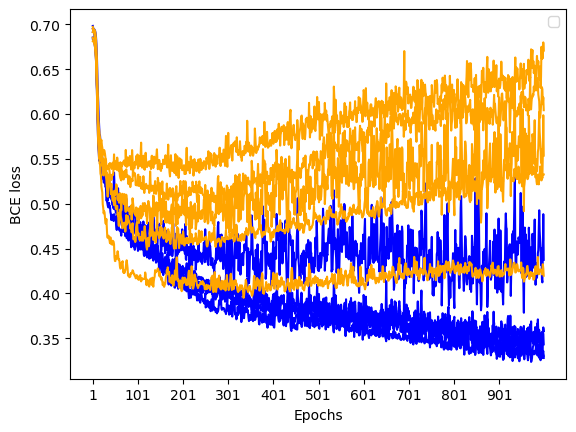

In [28]:
import matplotlib.pyplot as plt

all_val_losses = np.moveaxis(np.array(all_val_losses), 0, 1)
all_train_losses = np.moveaxis(np.array(all_train_losses), 0, 1)
plt.plot(all_train_losses, color='blue')
plt.plot(all_val_losses, color='orange')
plt.xlabel("Epochs")
plt.xticks(range(0, 1000, 100), range(1, 1001, 100))
plt.ylabel("BCE loss")
plt.legend(loc="upper right")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


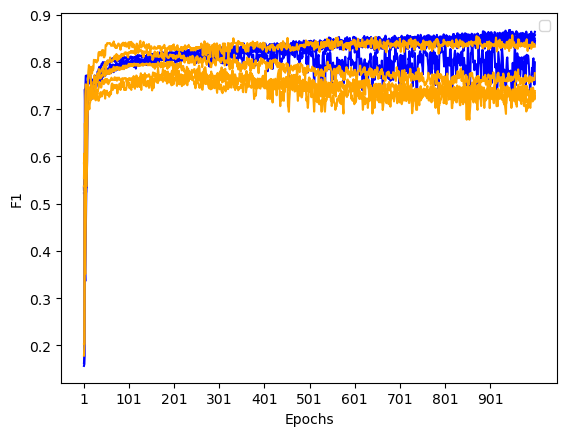

In [29]:
all_val_f1 = np.moveaxis(np.array(all_val_f1), 0, 1)
all_train_f1 = np.moveaxis(np.array(all_train_f1), 0, 1)
plt.plot(all_train_f1, color='blue')
plt.plot(all_val_f1, color='orange')
plt.xlabel("Epochs")
plt.xticks(range(0, 1000, 100), range(1, 1001, 100))
plt.ylabel("F1")
plt.legend(loc="upper right")
plt.show()

In [31]:
#%%capture
from tqdm import tqdm
from tqdm import tqdm
import torch.nn as nn
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
import torch

print("Training Model....")
NUM_EPOCHS = 90
NUM_CHANNELS = 21
NUM_CLASSES = 2
NUM_NODE_FEATURES = 51
BATCH_SIZE = 128
DEVICE = torch.device("cpu")

model = ChebNetGCN(NUM_NODE_FEATURES, 32, NUM_CHANNELS, 32, NUM_CLASSES)
loss_func = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
encoder = OneHotEncoder()
train_y_ohe = encoder.fit_transform(train_y).toarray()
test_y_ohe = encoder.fit_transform(test_y).toarray()
    
train_iter = data_loader(train_X , train_graphs, train_y_ohe, DEVICE, BATCH_SIZE, shuffle=True)
test_iter = data_loader(test_X , test_graphs, test_y_ohe, DEVICE, BATCH_SIZE, shuffle=False)
  
for epoch in tqdm(range(1, NUM_EPOCHS + 1)):
    loss_sum, n = 0.0, 0
    model.train()
    for t, (x, A, y) in enumerate(train_iter):
        optimizer.zero_grad()
        x = x.float()
        A = A.float()
        y_pred = model(x, A)
        loss = loss_func(y_pred, y)
        loss_sum += loss#.item()
        loss.backward()
        optimizer.step()

Training Model....


100%|█████████████████████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.21it/s]


In [32]:
train_acc = cal_accuracy(model, train_iter)
print("Accuracy: ", train_acc[0])
print("Precision: ", train_acc[2])
print("Recall: ", train_acc[3])
print("F1: ", train_acc[4])
print("Confusion Matrix: ", train_acc[1])

Accuracy:  0.8125502815768303
Precision:  0.8187558725519444
Recall:  0.8125502815768303
F1:  0.798653466062781
Confusion Matrix:  [[218 195]
 [ 38 792]]


In [33]:
test_acc = cal_accuracy(model, test_iter)
print("Accuracy: ", test_acc[0])
print("Precision: ", test_acc[2])
print("Recall: ", test_acc[3])
print("F1: ", test_acc[4])
print("Confusion Matrix: ", test_acc[1])

Accuracy:  0.8308823529411765
Precision:  0.8331040271360088
Recall:  0.8308823529411765
F1:  0.8226632818799455
Confusion Matrix:  [[28 18]
 [ 5 85]]
